# Tutorial: K562 HCT116 SP1 single-cell calling cards data. 

In this data, we test transcription factor SP1 bindings in cel lines K562 and HCT116 by single-cell(sc) calling cards techenology. The data is from [Moudgil et al., Cell. (2020)](https://doi.org/10.1016/j.cell.2020.06.037) and can be downloaded from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE148448).

In this tutorial, we will call peaks with backgound, make annotation, compare peaks with Chip-seq reference data, and do differential peak analysis. 

In [1]:
import pycallingcards as cc
import numpy as np
import pandas as pd
import scanpy as sc

We start by reading qbed data. In this data, one row is one insertion and columns indicate the chromosome, start point and end point, reads number, the direction and cell barcode of each insertion. For example, the first row means one insertion is in Chromosome 1 and starts from 30116 to 30120. The reads number is 12 with direction going from 5' to 3'. The barcode of the cell is CCCAATCCATCGGTTA-1. Note that the barcodes of the cell would also be consistent with scRNA-seq data.

Use ```cc.rd.read_qbed(filename)``` to read your own ccf data.

In [2]:
# read experiement data
HCT116_SP1 = cc.datasets.SP1_K562HCT116_data(data="HCT116_SP1_qbed")
HCT116_SP1

,Chr,Start,End,Reads,Direction,Barcodes
0,chr1,30116,30120,5,-,CCCAATCCATCGGTTA-1
1,chr1,34568,34572,3,-,CCTTCGAAGGGCTTCC-1
2,chr1,36736,36740,29,+,ACGAGCCGTATAGGTA-1
3,chr1,42447,42451,3,-,CTCTACGTCGGAGCAA-1
4,chr1,89697,89701,119,-,AGCTCTCGTTTGTTTC-1
...,...,...,...,...,...,...
77205,chrY,25518788,25518792,2,+,TGGGCGTTCGAACGGA-1
77206,chrY,56987633,56987637,13,+,CAGTCCTAGGCACATG-1
77207,chrY,57080855,57080859,17,+,CGGAGCTCATCGACGC-1
77208,chrY,57080855,57080859,7,+,GTAACGTAGTTACGGG-1


In [3]:
# read backgound data 
HCT116_brd4 = cc.datasets.SP1_K562HCT116_data(data="HCT116_brd4_qbed")
HCT116_brd4 

,Chr,Start,End,Reads,Direction,Barcodes
0,chr1,89697,89701,14,+,TCTGAGACAATGGTCT-1
1,chr1,89697,89701,8,+,CAGCGACCAAATACAG-1
2,chr1,203932,203936,99,+,TTCTCCTTCTACTTAC-1
3,chr1,204063,204067,5,-,TGTTCCGGTGTAAGTA-1
4,chr1,204063,204067,7,-,CAAGATCTCGACCAGC-1
...,...,...,...,...,...,...
37769,chrY,18037315,18037319,9,-,GCAGTTAAGATCTGAA-1
37770,chrY,24036504,24036508,168,+,GCAGTTAAGATCTGAA-1
37771,chrY,24036504,24036508,508,+,CATATGGCAGCCAGAA-1
37772,chrY,25633622,25633626,13,-,GCAGTTAAGATCTGAA-1


Because insertions are discrete, we now need to call peaks to deduce potential binding sites. Three different methods (*CCcaller, cc_tools, Blockify*) are available along with three different species (*hg38, mm10, sacCer3*). 

 
In this setting, we use ***cc_tools*** in *human*('hg38') data. *window_size* is the most important parameter for *cc_tools*, it is highly related to the length of a peak. 1000-3500 is a good fit for *window_size*. *step_size* is another important paramenter and it controls how careful we are at looking into the chromosomes. 500-1000 is good for *step_size*. *pvalue_cutoffTTAA* is the pvalue cutoff for TTAA data and *pvalue_cutoffbg* is the pvalue cutoff for the background ccf data. Normally, the setting for *pvalue_cutoffbg* is higher than *pvalue_cutoffTTAA*, but both should not exceed 0.1. 

In [4]:
peak_data_HCT116 = cc.pp.call_peaks(HCT116_SP1, HCT116_brd4, method = "cc_tools", reference = "hg38",  window_size = 2000, step_size = 500,
                  pvalue_cutoffTTAA = 0.001, pvalue_cutoffbg = 0.1, lam_win_size = None,  pseudocounts = 0.1, record = True, save = "peak_HCT116.bed")
peak_data_HCT116

For the cc_tools method with background, [expdata, background, reference, pvalue_cutoffbg, pvalue_cutoffTTAA, lam_win_size, window_size, step_size, extend, pseudocounts, test_method, min_insertions, record] would be utilized.


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


,Chr,Start,End,Center,Experiment Insertions,Background insertions,Reference Insertions,pvalue Reference,pvalue Background,Fraction Experiment,TPH Experiment,Fraction background,TPH background,TPH background subtracted
0,chr1,906689,907160,906957.0,5,0,3,3.099334e-09,1.546531e-04,0.000065,6475.845098,0.000000,0.000000,6475.845098
1,chr1,999921,1000324,1000121.0,20,0,1,0.000000e+00,0.000000e+00,0.000259,25903.380391,0.000000,0.000000,25903.380391
2,chr1,1156947,1157863,1157660.0,11,0,2,0.000000e+00,1.274899e-09,0.000142,14246.859215,0.000000,0.000000,14246.859215
3,chr1,1692740,1693542,1693339.0,6,0,3,5.135270e-11,1.546531e-04,0.000078,7771.014117,0.000000,0.000000,7771.014117
4,chr1,1744492,1746808,1746605.0,11,0,7,0.000000e+00,1.274899e-09,0.000142,14246.859215,0.000000,0.000000,14246.859215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3009,chrY,1245503,1247177,1245703.0,5,0,7,1.652897e-09,4.678840e-03,0.000065,6475.845098,0.000000,0.000000,6475.845098
3010,chrY,1280372,1281989,1281786.0,5,0,3,1.426995e-09,4.678840e-03,0.000065,6475.845098,0.000000,0.000000,6475.845098
3011,chrY,1586317,1587733,1587530.0,7,0,8,3.370637e-13,1.546531e-04,0.000091,9066.183137,0.000000,0.000000,9066.183137
3012,chrY,2391936,2392440,2392237.0,6,1,2,1.985434e-11,9.958372e-02,0.000078,7771.014117,0.000026,2647.323556,5123.690561


In order to choose the suitable method and parameters for peak calling, please take a look at the genome areas. We stongly advise to adjust the parameters for ```cc.pp.callpeaks()``` to call better peaks.

In this plot, the colored ones are the experiment qbed data and the gray ones are the background data. The top section is insertions and their read counts. One dot is an insertion and the height is log(reads+1). The middle section is the distribution of insertions. The bottom section represents reference genes and peaks. 


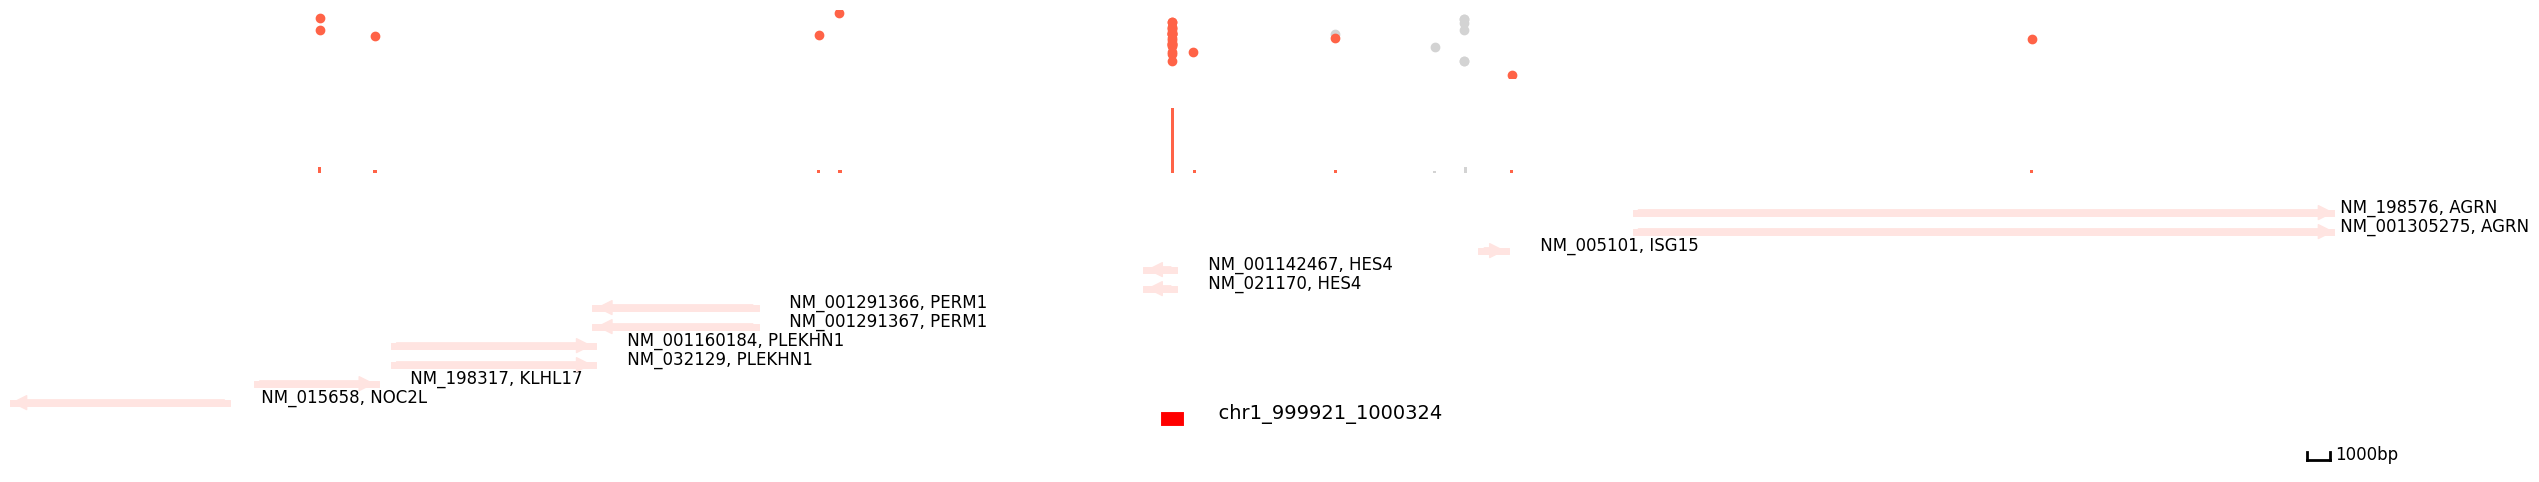

In [5]:
cc.pl.draw_area("chr1",999921,1000324,50000,peak_data_HCT116, HCT116_SP1, "hg38", HCT116_brd4,
                figsize = (30,6),peak_line = 1,save = False,plotsize = [1,1,4], example_length = 1000)

We can also visualize our data in [WashU Epigenome Browser](http://epigenomegateway.wustl.edu/browser/) directly. 
Notice that this link only valid for 24hrs, please rerun it if you want to use it.

In [6]:
qbed = {"SP1":HCT116_SP1, "Brd4": HCT116_brd4}
bed = {"peak":peak_data_HCT116}
cc.pl.WashU_browser_url(qbed = qbed,bed = bed,genome = 'hg38')

All qbed addressed
All bed addressed
Uploading files
Please click the following link to see the data on WashU Epigenome Browser directly.
https://epigenomegateway.wustl.edu/browser/?genome=hg38&hub=https://companion.epigenomegateway.org//task/c1bdc7483e506b391ff90b3aa7acf576/output//datahub.json


We advise to look at the whole chromosome and see the distribution of peaks to make sure everything is going accordingly.

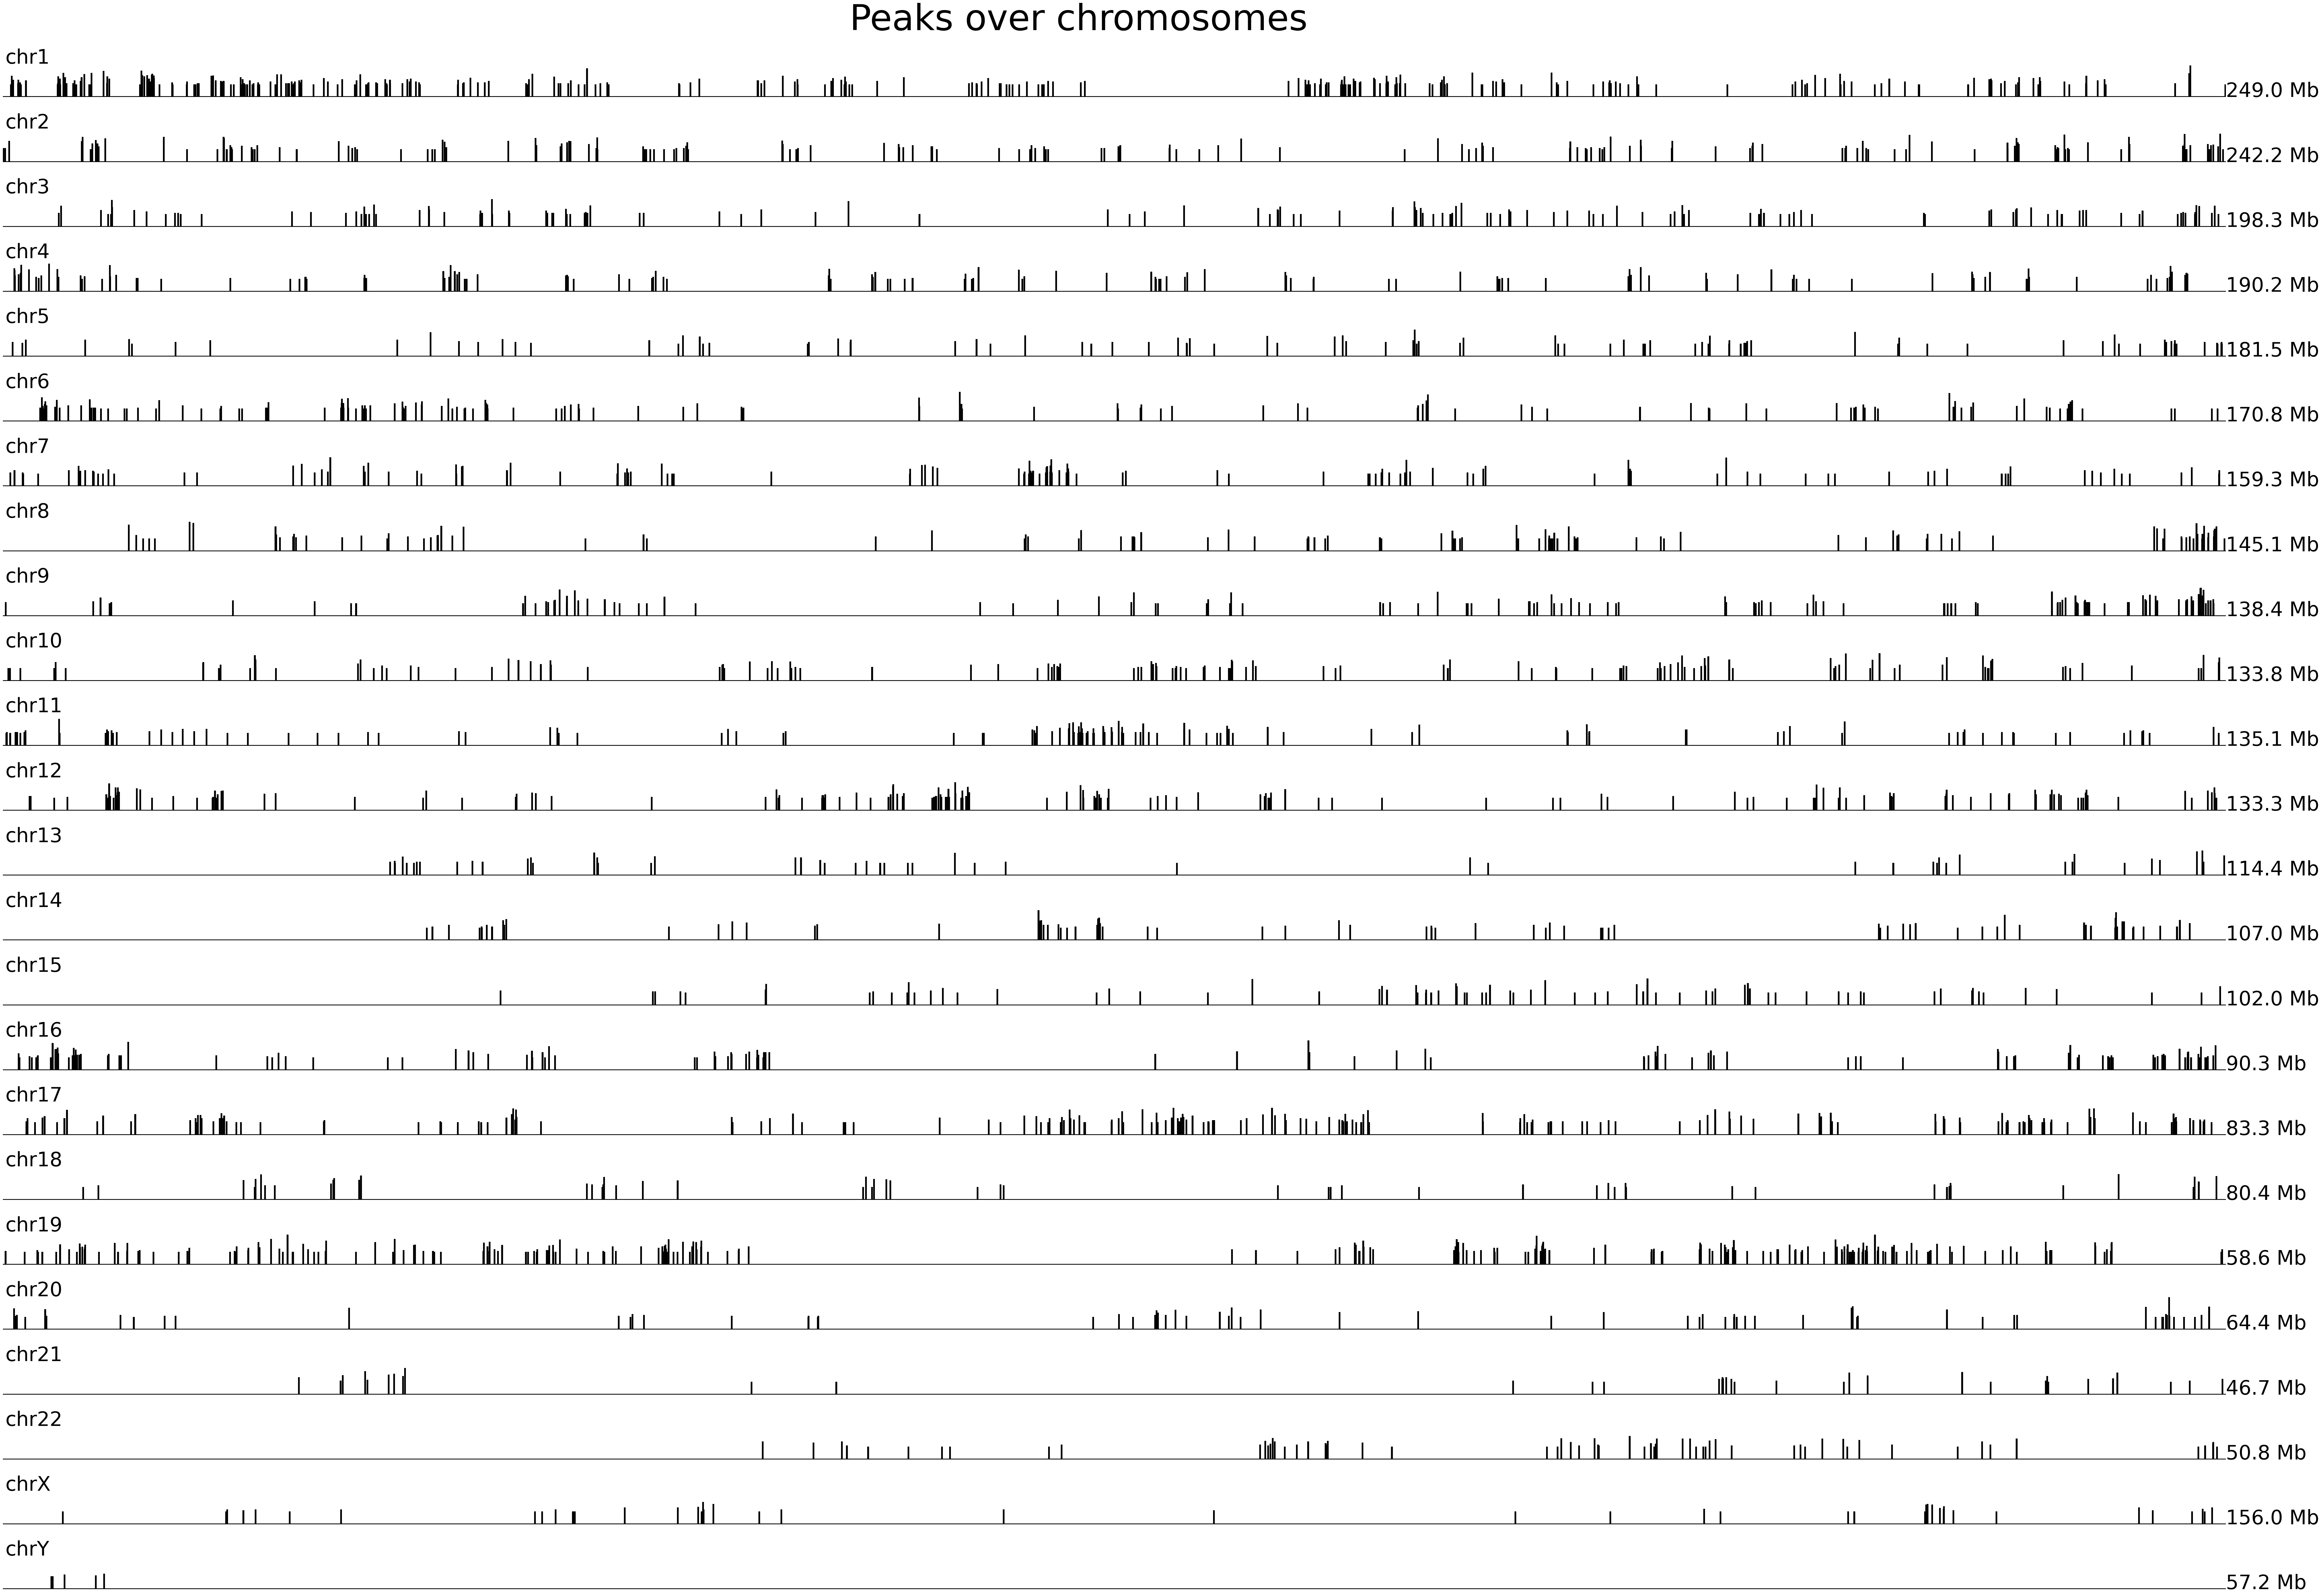

In [7]:
cc.pl.whole_peaks(peak_data_HCT116, reference = "hg38", figsize=(100, 70), height_scale = 1.7)

We then check the peak with reference Chip-seq data of SP1 in HCT116 from [ENCSR000BSF](https://www.encodeproject.org/experiments/ENCSR000BSF/) (use the bigWig file [ENCFF587ZMX](https://www.encodeproject.org/files/ENCFF587ZMX/) generated by it).

Download the data, if needed, with:

``` Python
    !wget https://www.encodeproject.org/files/ENCFF587ZMX/@@download/ENCFF587ZMX.bigWig
```


We first calculate the signal of the Chip-seq signal around the peak.

In [8]:
mtx_HCT116 = cc.pl.calculate_signal(peak_data_HCT116, 
                                    chipseq_signal = "ENCFF587ZMX.bigWig")

100%|██████████| 3014/3014 [00:24<00:00, 121.31it/s]


Visualize it by the plotting the signal values.

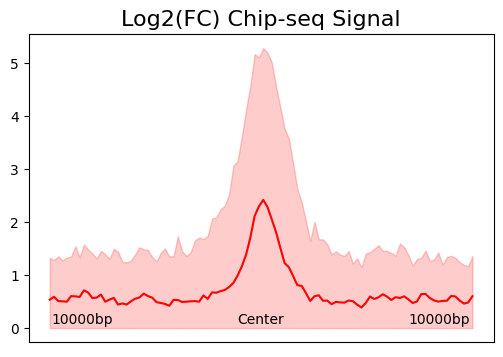

In [9]:
cc.pl.signal_plot(mtx_HCT116, alpha = 0.05, figsize=(6, 4))

Visualized by the plotting the signal heatmap plot.

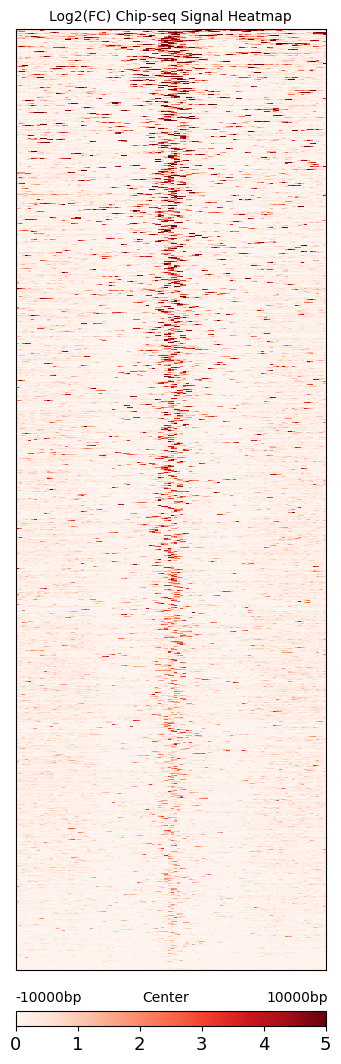

In [10]:
cc.pl.signal_heatmap(mtx_HCT116,pad = 0.035)

Call motif to check the peak results.

In [11]:
cc.tl.call_motif("peak_HCT116.bed",reference ="hg38",save_homer = "Homer/peak_HCT116", 
                 homer_path = "/ref/rmlab/software/homer/bin", num_cores=8)

Peak data peak_HCT116.bed is used here.



	Position file = peak_HCT116.bed
	Genome = hg38
	Output Directory = Homer/peak_HCT116
	Fragment size set to 1000
	Using 8 CPUs
	Will not run homer for de novo motifs
	Found mset for "human", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 3014
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 3014
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 1000 bp fragments found.

	Extracting sequences from file: /ref/rmlab/software/homer/.//data/genomes/hg38///genome.fa
	Looking for peak sequences in a single file (/ref/rmlab/software/homer/.//data/genomes/hg38///genome.fa)
	Extracting 334 sequences from chr1
	Extracting 147 sequences from chr10
	Extracting 132 sequences from chr11
	Extracting 179 sequences fr

Finished!


	Skipping...
	Job finished - if results look good, please send beer to ..

	Cleaning up tmp files...



In the motif analysis result, SP1 is the most significant motif.


<img src="peak_HCT116.png" alt="drawing" width="800"/>

Do the exact same thing for K562 SP1 data.

In [12]:
# read experiment data
K562_SP1 = cc.datasets.SP1_K562HCT116_data(data="K562_SP1_qbed")
K562_SP1

,Chr,Start,End,Reads,Direction,Barcodes
0,chr1,16529,16533,163,-,GCTCCTAAGTACGTTC-1
1,chr1,29884,29888,10,+,CTCACACCAGACGCTC-1
2,chr1,29884,29888,155,+,TGGCCAGCACCCATTC-1
3,chr1,29884,29888,285,+,GTGGGTCCACGGCCAT-1
4,chr1,29884,29888,7,+,CGTCTACTCAACACGT-1
...,...,...,...,...,...,...
327460,chrY,57061562,57061566,6,+,CTCATTATCATCATTC-1
327461,chrY,57061562,57061566,67,+,TGCGTGGCATTAGGCT-1
327462,chrY,57145084,57145088,2,-,ACATACGTCGCGCCAA-1
327463,chrY,57148630,57148634,2,-,TATGCCCGTACAGTTC-1


In [13]:
# read background data
K562_brd4 =cc.datasets.SP1_K562HCT116_data(data="K562_brd4_qbed")
K562_brd4 

,Chr,Start,End,Reads,Direction,Barcodes
0,chr1,30238,30242,3,+,TTTACTGCATAAAGGT-1
1,chr1,30355,30359,2,-,ATCACGAAGAGTAATC-1
2,chr1,30355,30359,70,+,TTGAACGCAAATCCGT-1
3,chr1,31101,31105,2,+,CCTCAGTCATCAGTAC-1
4,chr1,32116,32120,5,+,CTAGTGAAGACAAAGG-1
...,...,...,...,...,...,...
107380,chrY,57080210,57080214,9,-,AAGGAGCCAGTATAAG-1
107381,chrY,57087785,57087789,24,-,CGAGCCAGTCTCTCTG-1
107382,chrY,57144853,57144857,5,+,GAAGCAGTCCCATTTA-1
107383,chrY,57183772,57183776,2,-,TCTTTCCTCTTGCCGT-1


In [14]:
peak_data_K562 = cc.pp.call_peaks(K562_SP1, K562_brd4, method = "cc_tools", reference = "hg38", window_size = 2000, step_size = 500,
                  pvalue_cutoffTTAA = 0.0001,  pvalue_cutoffbg = 0.1, lam_win_size = None,  pseudocounts = 0.1, record = True, save = "peak_k562.bed")
peak_data_K562

For the cc_tools method with background, [expdata, background, reference, pvalue_cutoffbg, pvalue_cutoffTTAA, lam_win_size, window_size, step_size, extend, pseudocounts, test_method, min_insertions, record] would be utilized.


100%|██████████| 24/24 [02:12<00:00,  5.52s/it]


,Chr,Start,End,Center,Experiment Insertions,Background insertions,Reference Insertions,pvalue Reference,pvalue Background,Fraction Experiment,TPH Experiment,Fraction background,TPH background,TPH background subtracted
0,chr1,29684,30087,29884.0,6,0,1,8.878753e-11,1.546531e-04,0.000018,1832.256882,0.000000,0.000000,1832.256882
1,chr1,36239,38107,37578.0,24,2,15,0.000000e+00,1.486029e-03,0.000073,7329.027530,0.000019,1862.457513,5466.570017
2,chr1,198893,201208,200869.0,28,2,11,0.000000e+00,6.927041e-05,0.000086,8550.532118,0.000019,1862.457513,6688.074605
3,chr1,203351,207161,205004.0,92,13,22,0.000000e+00,4.337485e-05,0.000281,28094.605530,0.000121,12105.973832,15988.631698
4,chr1,265549,266336,265749.0,5,0,3,3.731359e-08,4.678840e-03,0.000015,1526.880735,0.000000,0.000000,1526.880735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9871,chrY,15158250,15158653,15158450.0,11,0,1,0.000000e+00,1.546531e-04,0.000034,3359.137618,0.000000,0.000000,3359.137618
9872,chrY,16985442,16985845,16985642.0,5,0,2,1.806731e-09,4.678840e-03,0.000015,1526.880735,0.000000,0.000000,1526.880735
9873,chrY,19753311,19753714,19753511.0,33,0,1,0.000000e+00,2.269296e-13,0.000101,10077.412853,0.000000,0.000000,10077.412853
9874,chrY,21011133,21011828,21011333.0,5,0,4,2.510448e-09,4.678840e-03,0.000015,1526.880735,0.000000,0.000000,1526.880735


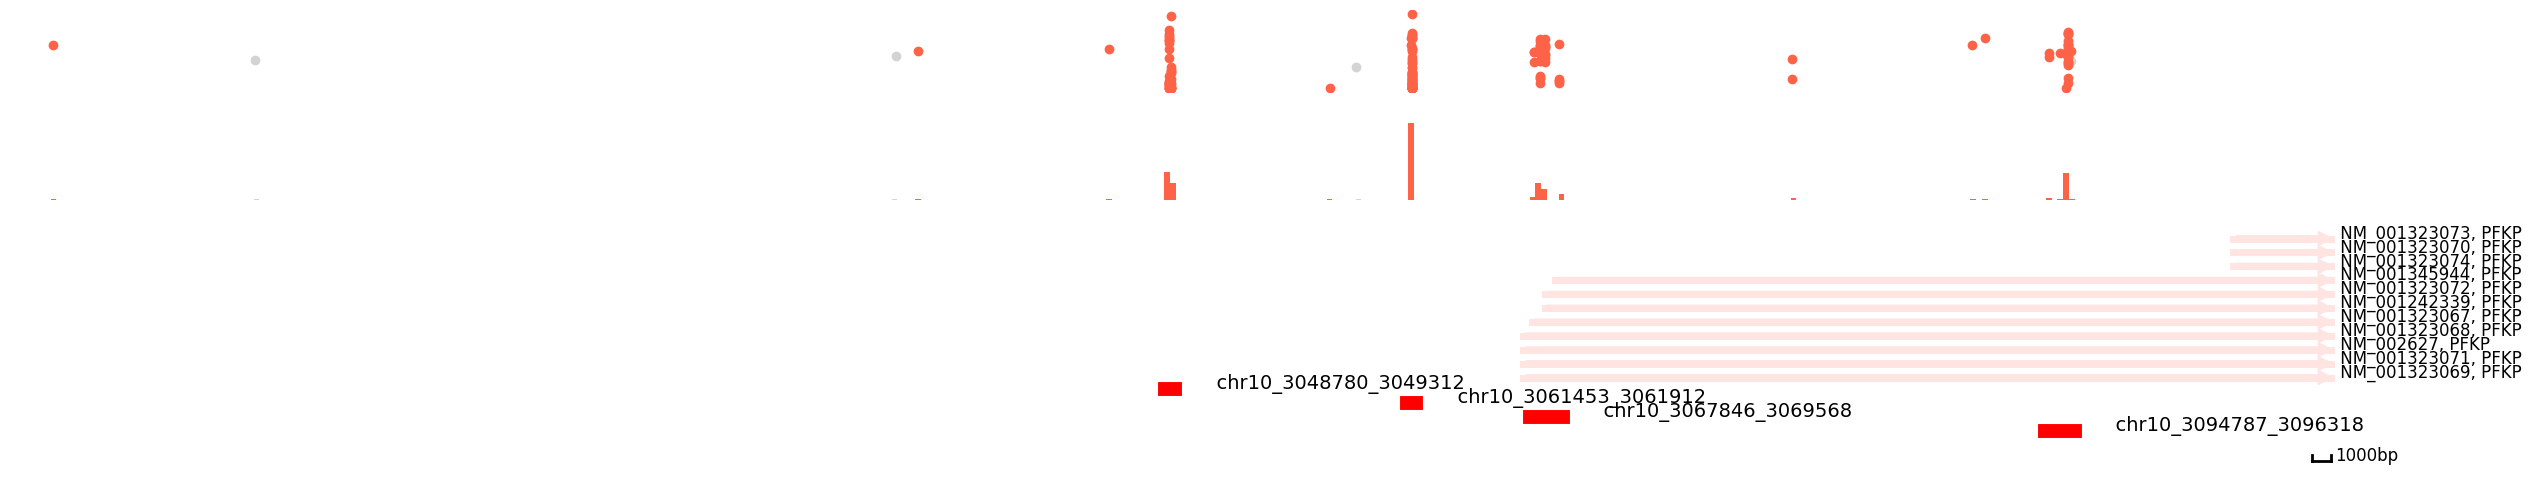

In [15]:
cc.pl.draw_area("chr10",3048452,3049913,60000,peak_data_K562,K562_SP1, "hg38", K562_brd4 ,
                figsize = (30,6),peak_line = 4,save = False,bins =400, plotsize = [1,1,3], example_length = 1000)

In [16]:
qbed = {"SP1":K562_SP1, "Brd4": K562_brd4}
bed = {"peak":peak_data_K562}
cc.pl.WashU_browser_url(qbed = qbed,bed = bed,genome = 'hg38')

All qbed addressed
All bed addressed
Uploading files
Please click the following link to see the data on WashU Epigenome Browser directly.
https://epigenomegateway.wustl.edu/browser/?genome=hg38&hub=https://companion.epigenomegateway.org//task/b525e3de0f797a0c28e853ad2299a9c7/output//datahub.json


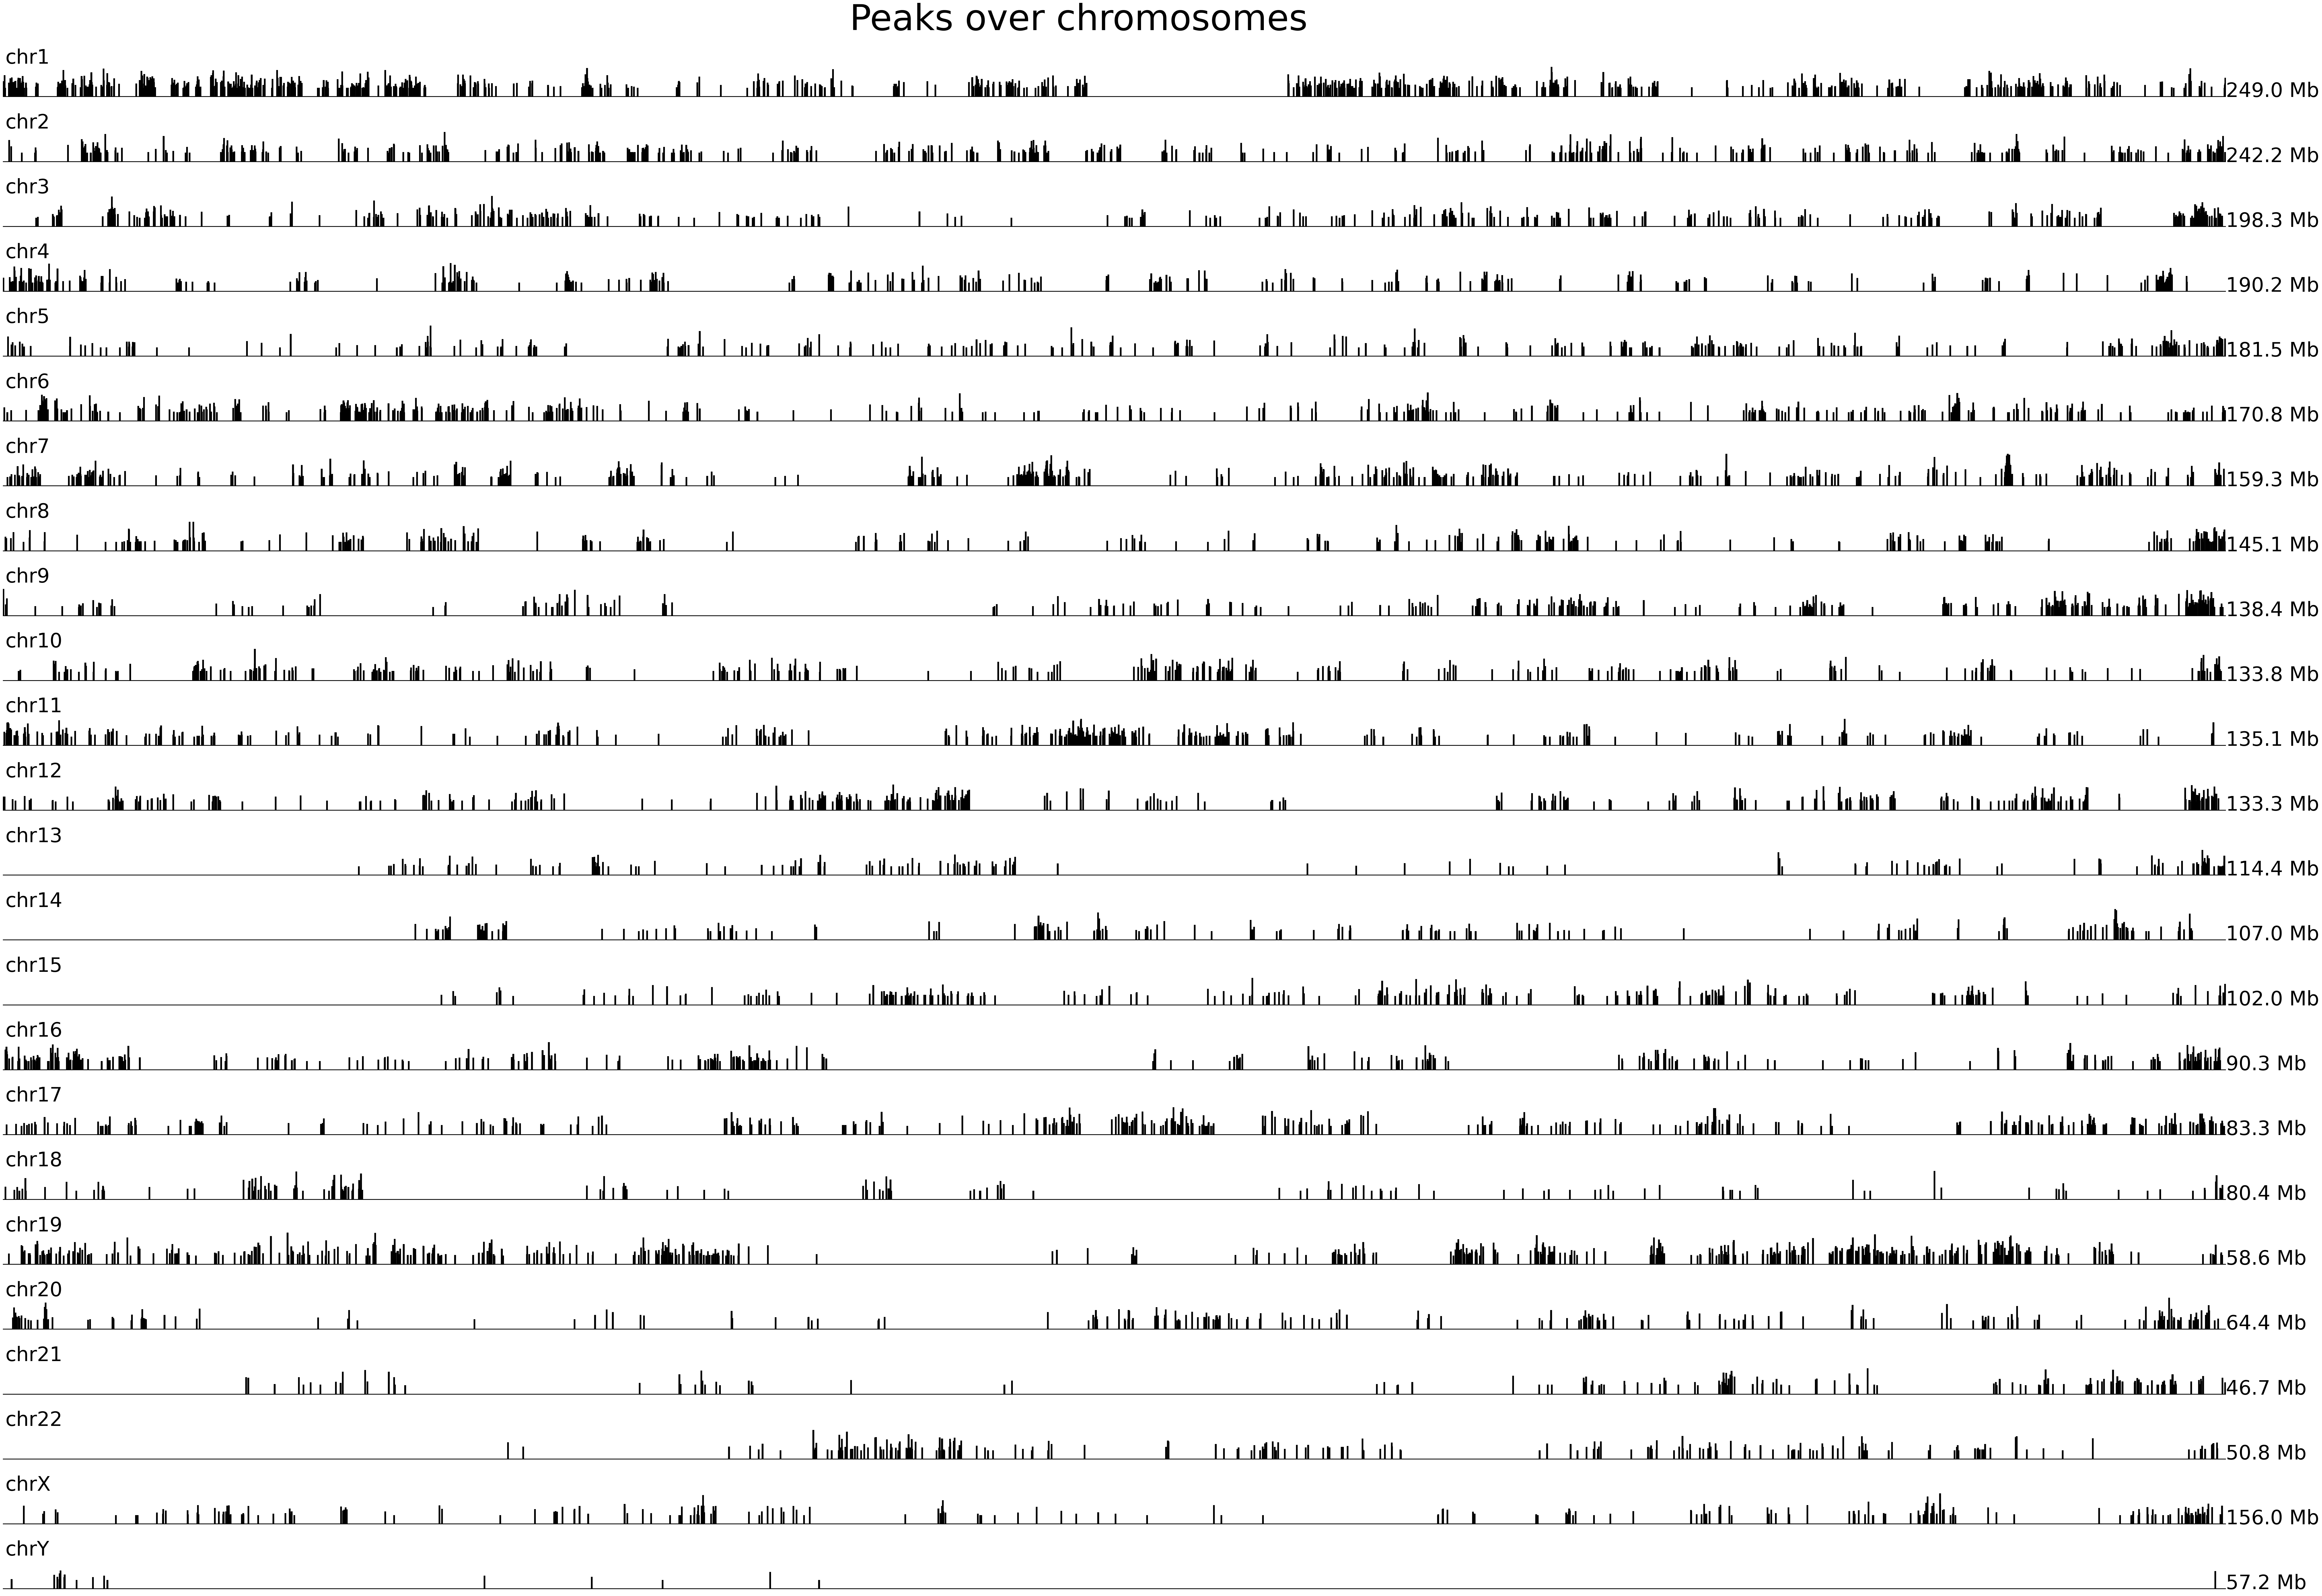

In [17]:
cc.pl.whole_peaks(peak_data_K562, reference = "hg38",figsize=(100, 70),height_scale = 1.7)

We can see that SP1 binds much more frequently in K562 than HCT116.

We can then check with reference Chip-seq data of SP1 in K562 from [ENCSR372IML](https://www.encodeproject.org/experiments/ENCSR372IML/) (and use the bigWig file [ENCFF588UII](https://www.encodeproject.org/files/ENCFF588UII/) generated by it）.

Download the data if needed:

``` Python
    !wget https://www.encodeproject.org/files/ENCFF588UII/@@download/ENCFF588UII.bigWig
```

In [18]:
mtx_K562 = cc.pl.calculate_signal(peak_data_K562, chipseq_signal = "ENCFF588UII.bigWig")

100%|██████████| 9876/9876 [01:06<00:00, 147.43it/s]


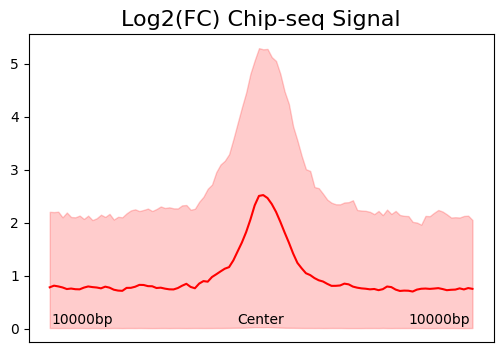

In [19]:
cc.pl.signal_plot(mtx_K562, alpha = 0.05, figsize=(6, 4))

/opt/apps/labs/rmlab/software/juanru/miniconda/lib/python3.9/site-packages/pycallingcards/plotting/_Chipseq.py:268: RuntimeWarning: Mean of empty slice
  np.log2(signalmtx[np.argsort(np.nanmean(signalmtx, axis=1)), :] + 1),


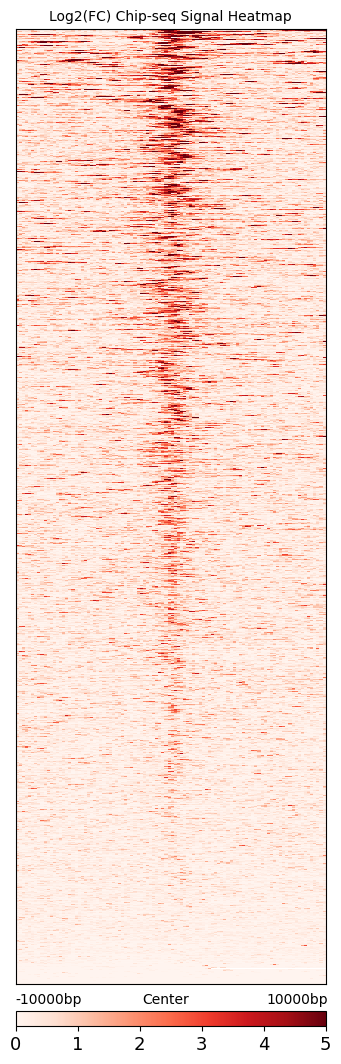

In [20]:
cc.pl.signal_heatmap(mtx_K562,pad =  0.023, belowlength = 100)

We can see that calling cards peaks are consistent with Chip-seq data. Peak centers tend to have a higher signal and the signal goes lower as the distance increases.

Call motif to check the peak results.

In [21]:
cc.tl.call_motif("peak_k562.bed",reference ="hg38",save_homer = "Homer/peak_k562", 
                 homer_path = "/ref/rmlab/software/homer/bin", num_cores=8)

Peak data peak_k562.bed is used here.



	Position file = peak_k562.bed
	Genome = hg38
	Output Directory = Homer/peak_k562
	Fragment size set to 1000
	Using 8 CPUs
	Will not run homer for de novo motifs
	Found mset for "human", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 9876
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 9876
		Redundant Peak IDs: 2
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Redunant Peaks found: Remove or rename these or some programs may have trouble...

	2 duplicate peak IDs out of 9876 total peaks
	Background files for 1000 bp fragments found.

	Extracting sequences from file: /ref/rmlab/software/homer/.//data/genomes/hg38///genome.fa
	Looking for peak sequences in a single file (/ref/rmlab/software/homer/.//data/genomes/hg38///genome.fa)
	Extracting 1130 sequences from chr1

Finished!


	Skipping...
	Job finished - if results look good, please send beer to ..

	Cleaning up tmp files...



In the motif analysis result, SP1 is the most significant motif.


<img src="peak_k562.png" alt="drawing" width="800"/>

Because we call peaks for two data separately, we need to combine two peaks together using [bedtools](https://bedtools.readthedocs.io/en/latest/) and [pybedtools](https://daler.github.io/pybedtools/).

In [22]:
import pybedtools
peak = cc.rd.combine_qbed([peak_data_HCT116, peak_data_K562])
peak = pybedtools.BedTool.from_dataframe(peak).merge().to_dataframe() 
peak_data = peak.rename(columns={"chrom":"Chr", "start":"Start", "end":"End"})
peak_data 

,Chr,Start,End
0,chr1,29684,30087
1,chr1,36239,38107
2,chr1,198893,201208
3,chr1,203351,207161
4,chr1,265549,266336
...,...,...,...
10888,chrY,15158250,15158653
10889,chrY,16985442,16985845
10890,chrY,19753311,19753714
10891,chrY,21011133,21011828


Check for the peaks again.

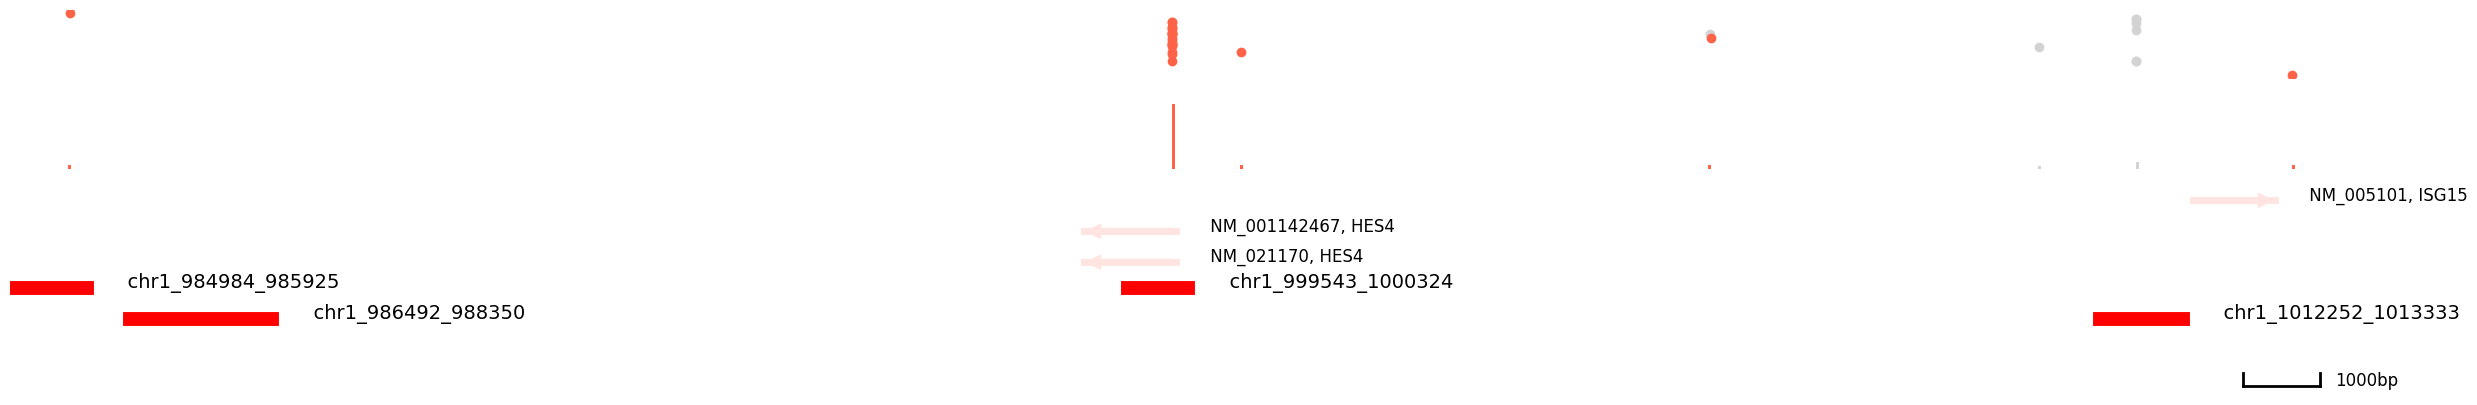

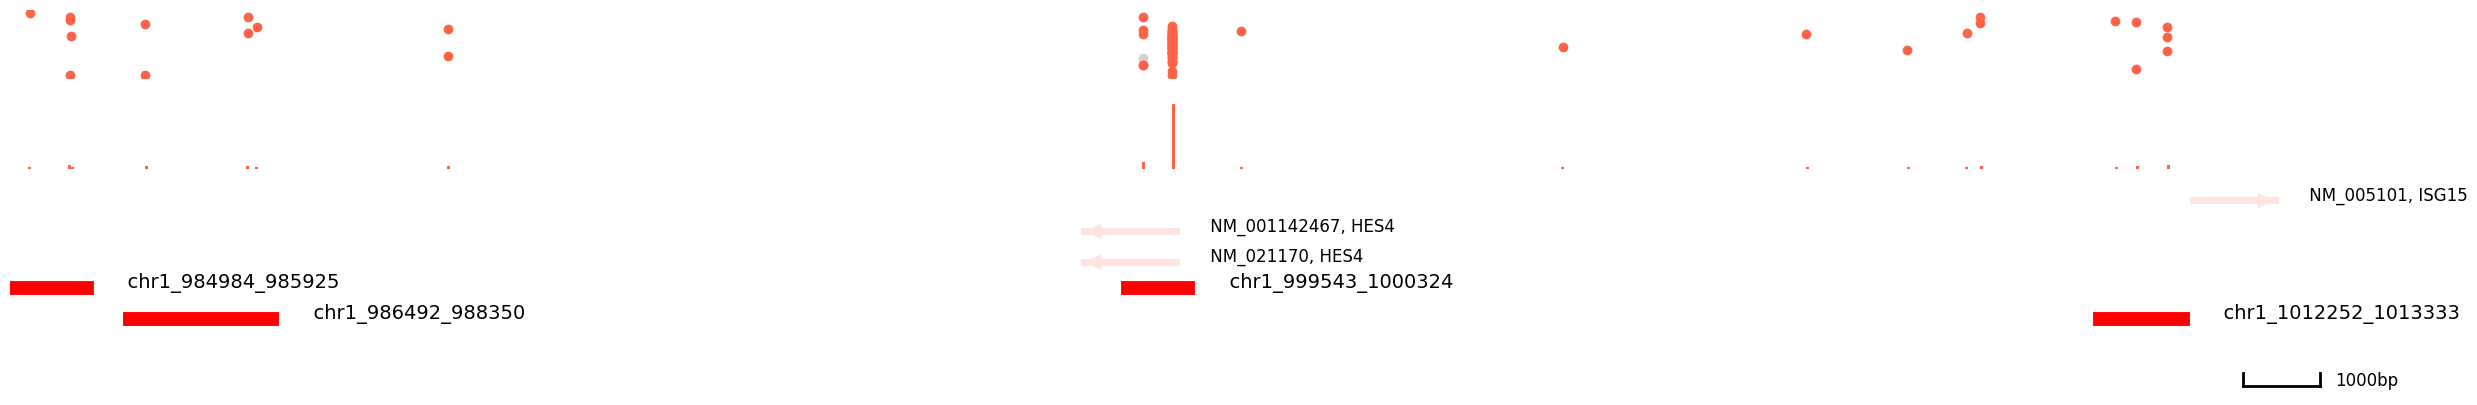

In [23]:
cc.pl.draw_area("chr1",999921,1000324,15000,peak_data, HCT116_SP1, "hg38", HCT116_brd4,
                figsize = (30,5),peak_line = 2,save = False,plotsize = [1,1,3],  example_length = 1000)
cc.pl.draw_area("chr1",999921,1000324,15000,peak_data, K562_SP1, "hg38", K562_brd4,
                figsize = (30,5),peak_line = 2,save = False,plotsize = [1,1,3],  example_length = 1000)

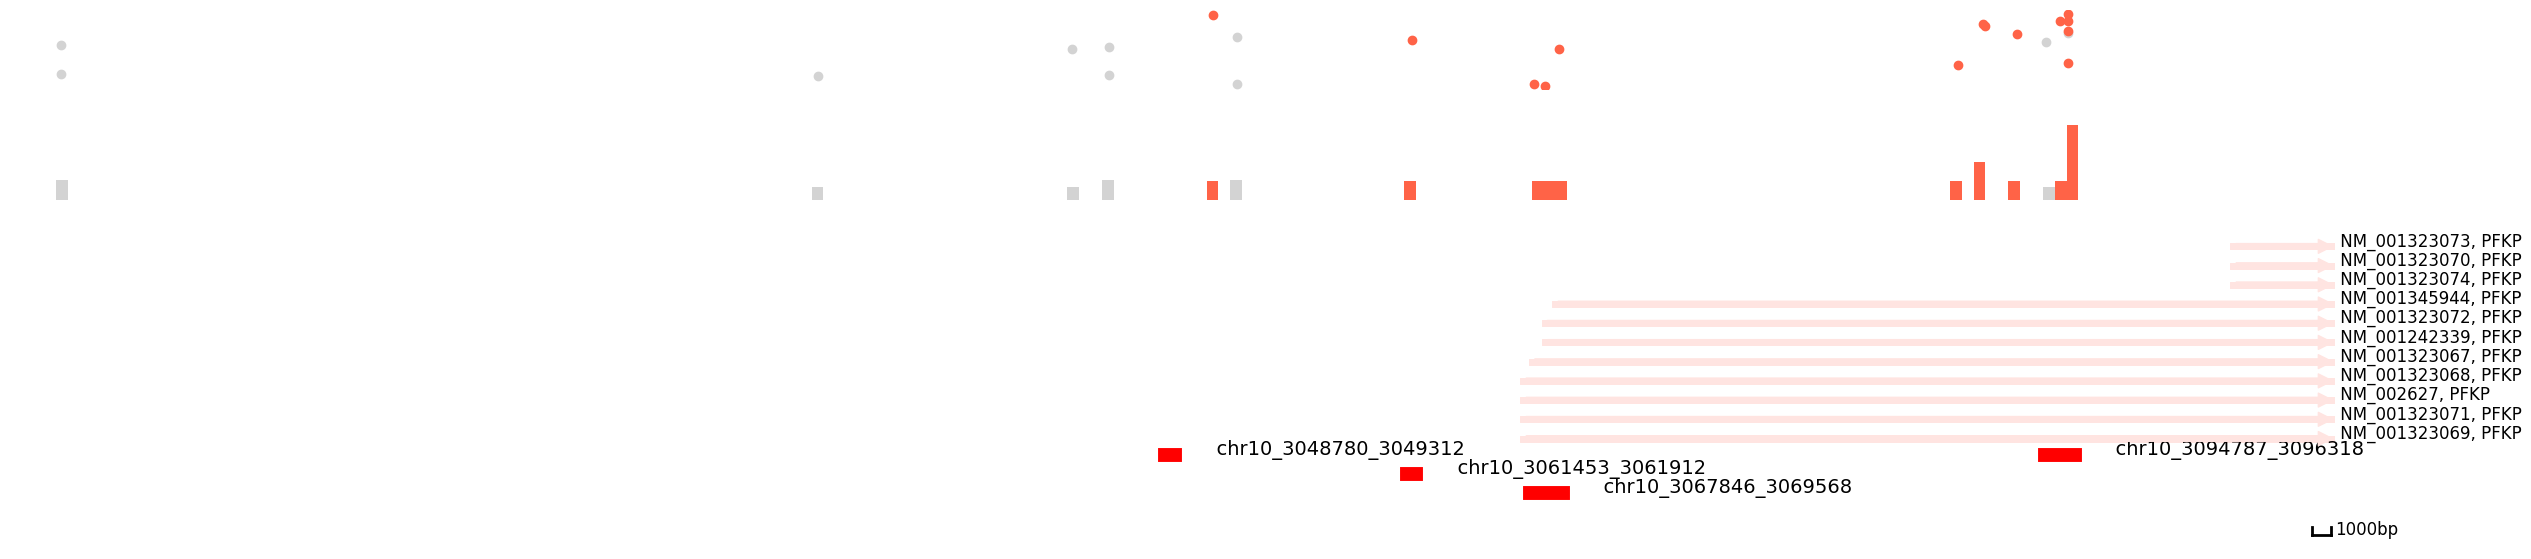

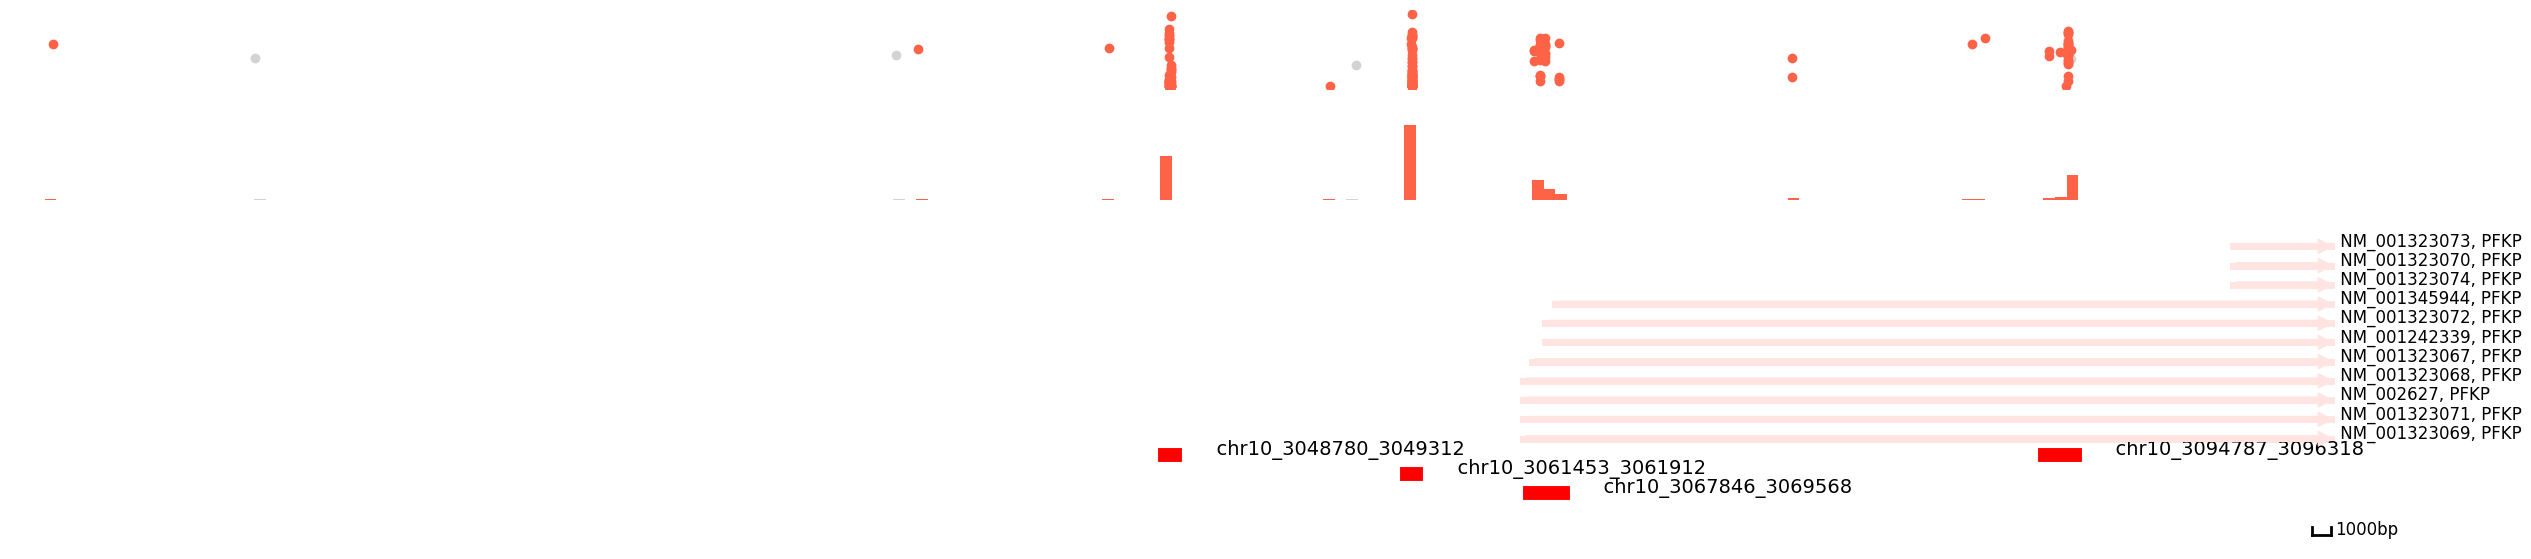

In [24]:
cc.pl.draw_area("chr10",3048452,3049913,60000,peak_data, HCT116_SP1, "hg38", HCT116_brd4,
                figsize = (30,7),peak_line = 3,save = False, bins = 200, plotsize = [1,1,4], example_length = 1000)
cc.pl.draw_area("chr10",3048452,3049913,60000,peak_data, K562_SP1, "hg38", K562_brd4,
                figsize = (30,7),peak_line = 3,save = False, bins = 200, plotsize = [1,1,4],  example_length = 1000)

Results seem to be good! Congratulations! Find out the closest genes for each peak for annotation.

In [25]:
peak_annotation = cc.pp.annotation(peak_data, reference = "hg38")
peak_annotation = cc.pp.combine_annotation(peak_data,peak_annotation)
peak_annotation

In the bedtools method, we would use bedtools in the default path. Set bedtools path by 'bedtools_path' if needed.


,Chr,Start,End,Nearest Refseq1,Gene Name1,Nearest Refseq2,Gene Name2
0,chr1,29684,30087,NR_036051,MIR1302-2,NR_024540,WASH7P
1,chr1,36239,38107,NR_026818,FAM138A,NR_036051,MIR1302-2
2,chr1,198893,201208,NR_026823,FAM138D,NR_107063,MIR6859-3
3,chr1,203351,207161,NR_026823,FAM138D,NR_107063,MIR6859-3
4,chr1,265549,266336,NR_026823,FAM138D,NR_107063,MIR6859-3
...,...,...,...,...,...,...,...
10888,chrY,15158250,15158653,NM_001206850,NLGN4Y,NR_046504,NLGN4Y-AS1
10889,chrY,16985442,16985845,NR_028083,FAM41AY1,NR_002160,FAM224B
10890,chrY,19753311,19753714,NM_001146706,KDM5D,NR_045128,TXLNGY
10891,chrY,21011133,21011828,NM_001039567,RPS4Y2,NM_001282471,PRORY


Combine the two experiment qbed files to make anndata object.

In [26]:
exp_qbed = pd.concat([K562_SP1,HCT116_SP1])
exp_qbed

,Chr,Start,End,Reads,Direction,Barcodes
0,chr1,16529,16533,163,-,GCTCCTAAGTACGTTC-1
1,chr1,29884,29888,10,+,CTCACACCAGACGCTC-1
2,chr1,29884,29888,155,+,TGGCCAGCACCCATTC-1
3,chr1,29884,29888,285,+,GTGGGTCCACGGCCAT-1
4,chr1,29884,29888,7,+,CGTCTACTCAACACGT-1
...,...,...,...,...,...,...
77205,chrY,25518788,25518792,2,+,TGGGCGTTCGAACGGA-1
77206,chrY,56987633,56987637,13,+,CAGTCCTAGGCACATG-1
77207,chrY,57080855,57080859,17,+,CGGAGCTCATCGACGC-1
77208,chrY,57080855,57080859,7,+,GTAACGTAGTTACGGG-1


Read the barocode file.

In [27]:
barcodes = cc.datasets.SP1_K562HCT116_data(data = "barcodes")
barcodes = barcodes.drop_duplicates(subset=['Index'])
barcodes

,Index,cluster
0,AAACCTGAGAAAGTGG-1,HCT116
1,AAACCTGAGACCGGAT-1,K562
2,AAACCTGAGACTAGAT-1,HCT116
3,AAACCTGAGAGCTTCT-1,HCT116
4,AAACCTGAGAGTACCG-1,HCT116
...,...,...
52206,TTTGTCATCTCCGGTT-1,K562
52207,TTTGTCATCTCGATGA-1,K562
52208,TTTGTCATCTCTAAGG-1,K562
52209,TTTGTCATCTGGAGCC-1,HCT116


Use qbed data, peak data and barcodes data to make a cell by peak anndata object.

In [28]:
adata_cc = cc.pp.make_Anndata(exp_qbed, peak_annotation, barcodes)
adata_cc

100%|██████████| 24/24 [00:02<00:00,  8.12it/s]


AnnData object with n_obs × n_vars = 51079 × 10893
    obs: 'cluster'
    var: 'Chr', 'Start', 'End', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

Although one peak should have many insertions, there is a chance that all the cells from the peak were filtered by the RNA preprocesssing. In this case, we advise to filter the peaks. Additionally, we also recommend to filter cells that have very few insertions.

In [29]:
cc.pp.filter_peaks(adata_cc, min_counts=5)
cc.pp.filter_peaks(adata_cc, min_cells=5)
adata_cc

AnnData object with n_obs × n_vars = 51079 × 10887
    obs: 'cluster'
    var: 'Chr', 'Start', 'End', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2', 'n_counts', 'n_cells'

Differential peak analysis will find out the significant binding for each group. In this example, we use *fisher exact test* to find out.

In [30]:
cc.tl.rank_peak_groups(adata_cc,"cluster",method = 'fisher_exact',key_added = 'fisher_exact')

100%|██████████| 2/2 [02:43<00:00, 81.76s/it]


Plot the results for differential peak analysis.

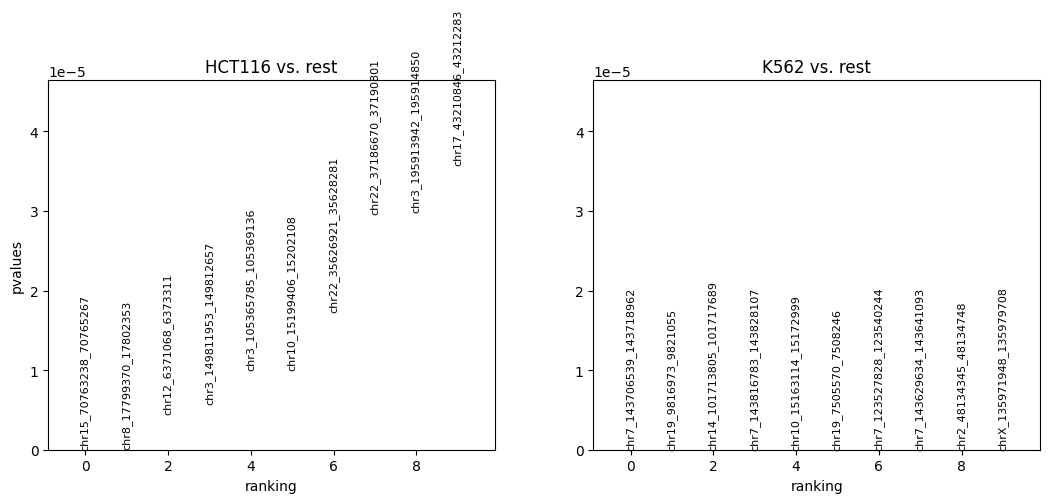

In [31]:
cc.pl.rank_peak_groups(adata_cc, key = 'fisher_exact')

Then, we take a look at the genome for highly differentiated peaks. The colored ones are the insertions for a specific cluster and the grey ones are the backgound insertion information. We can see a huge difference between SP1 bindings in HCT116 and SP1 bindings in K562.

In [32]:
bg_qbed = pd.concat([K562_brd4,HCT116_brd4])
bg_qbed

,Chr,Start,End,Reads,Direction,Barcodes
0,chr1,30238,30242,3,+,TTTACTGCATAAAGGT-1
1,chr1,30355,30359,2,-,ATCACGAAGAGTAATC-1
2,chr1,30355,30359,70,+,TTGAACGCAAATCCGT-1
3,chr1,31101,31105,2,+,CCTCAGTCATCAGTAC-1
4,chr1,32116,32120,5,+,CTAGTGAAGACAAAGG-1
...,...,...,...,...,...,...
37769,chrY,18037315,18037319,9,-,GCAGTTAAGATCTGAA-1
37770,chrY,24036504,24036508,168,+,GCAGTTAAGATCTGAA-1
37771,chrY,24036504,24036508,508,+,CATATGGCAGCCAGAA-1
37772,chrY,25633622,25633626,13,-,GCAGTTAAGATCTGAA-1


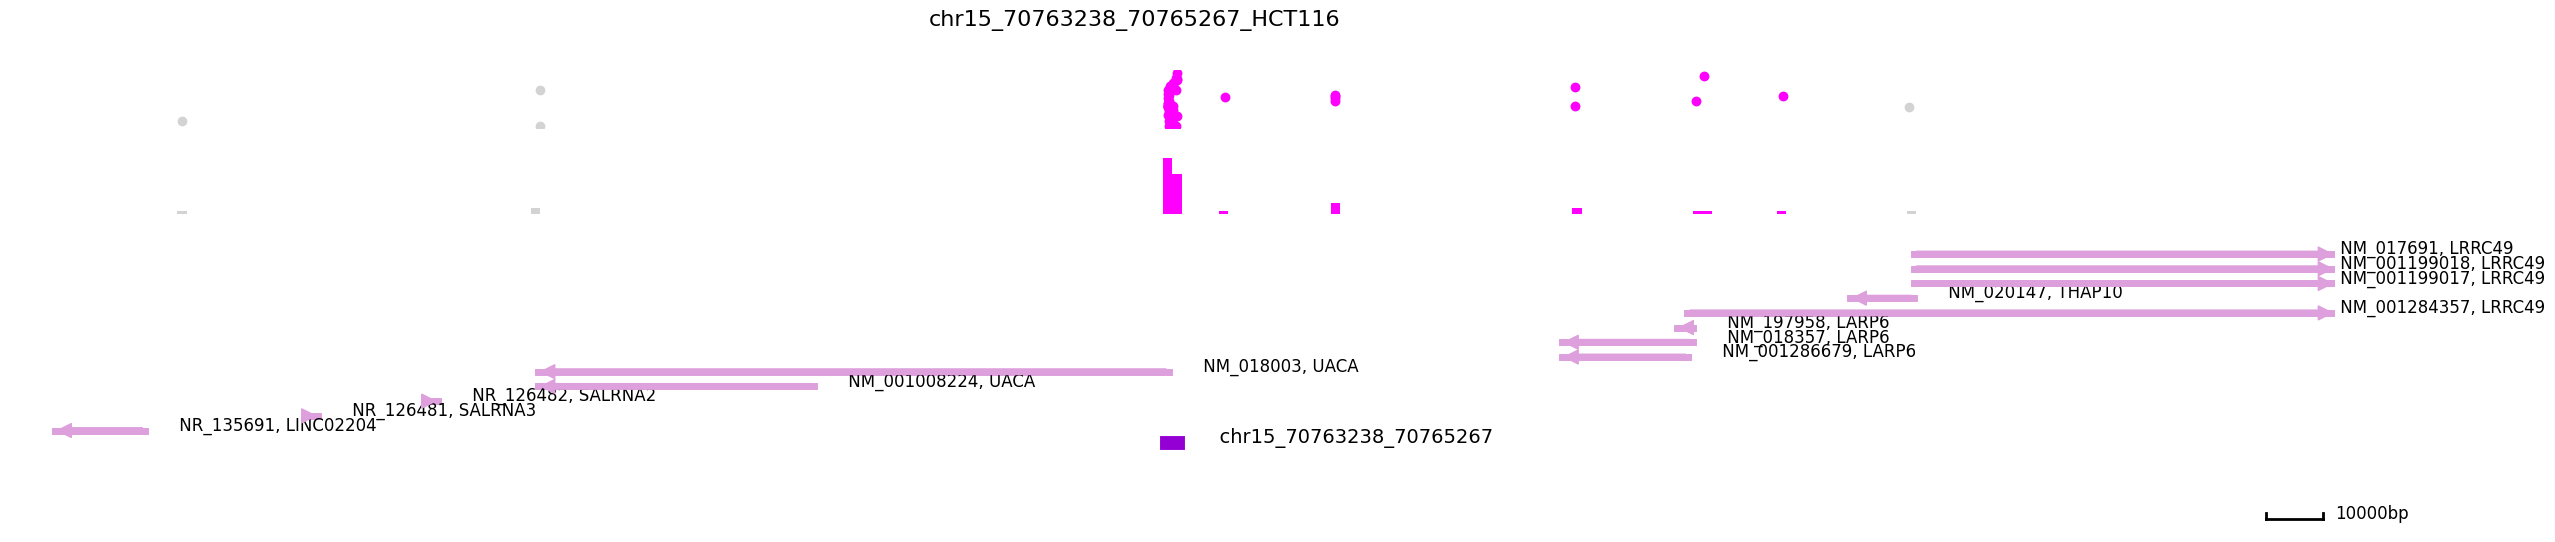

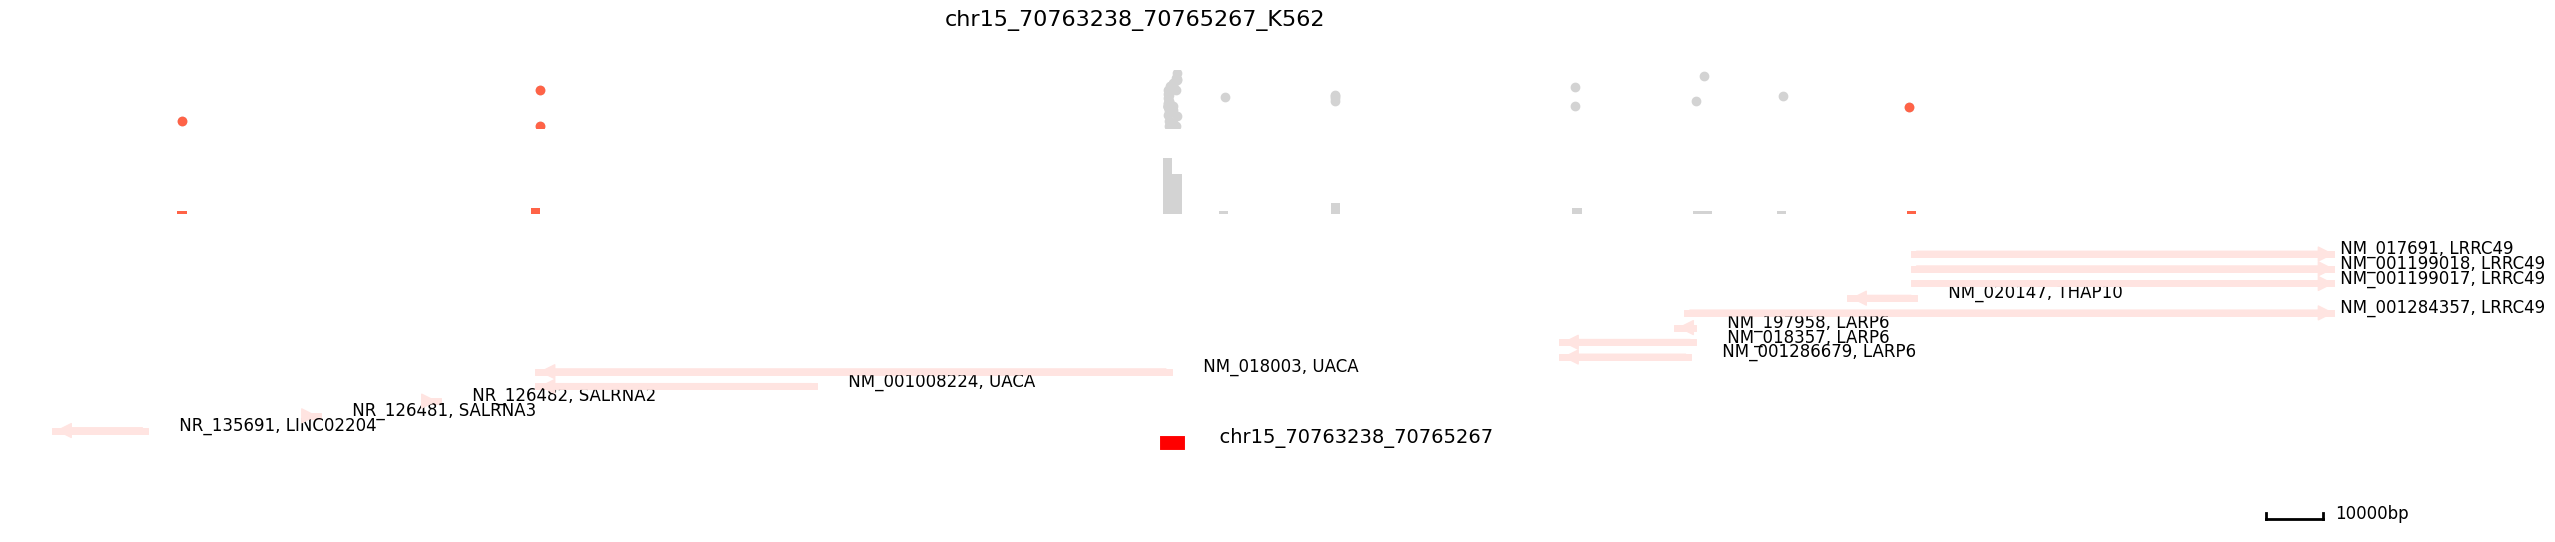

In [33]:
cc.pl.draw_area("chr15",70763238,70765267,200000,peak_data,exp_qbed,"hg38",adata = adata_cc,  bins = 250,
                name = "HCT116",key ='cluster',figsize = (30,6),peak_line = 4,color = "purple", plotsize = [1,1,5], title = "chr15_70763238_70765267_HCT116")
cc.pl.draw_area("chr15",70763238,70765267,200000,peak_data,exp_qbed,"hg38",adata = adata_cc, bins = 250,
                name = "K562",key ='cluster',figsize = (30,6),peak_line = 4,color = "red", plotsize = [1,1,5], title = "chr15_70763238_70765267_K562")

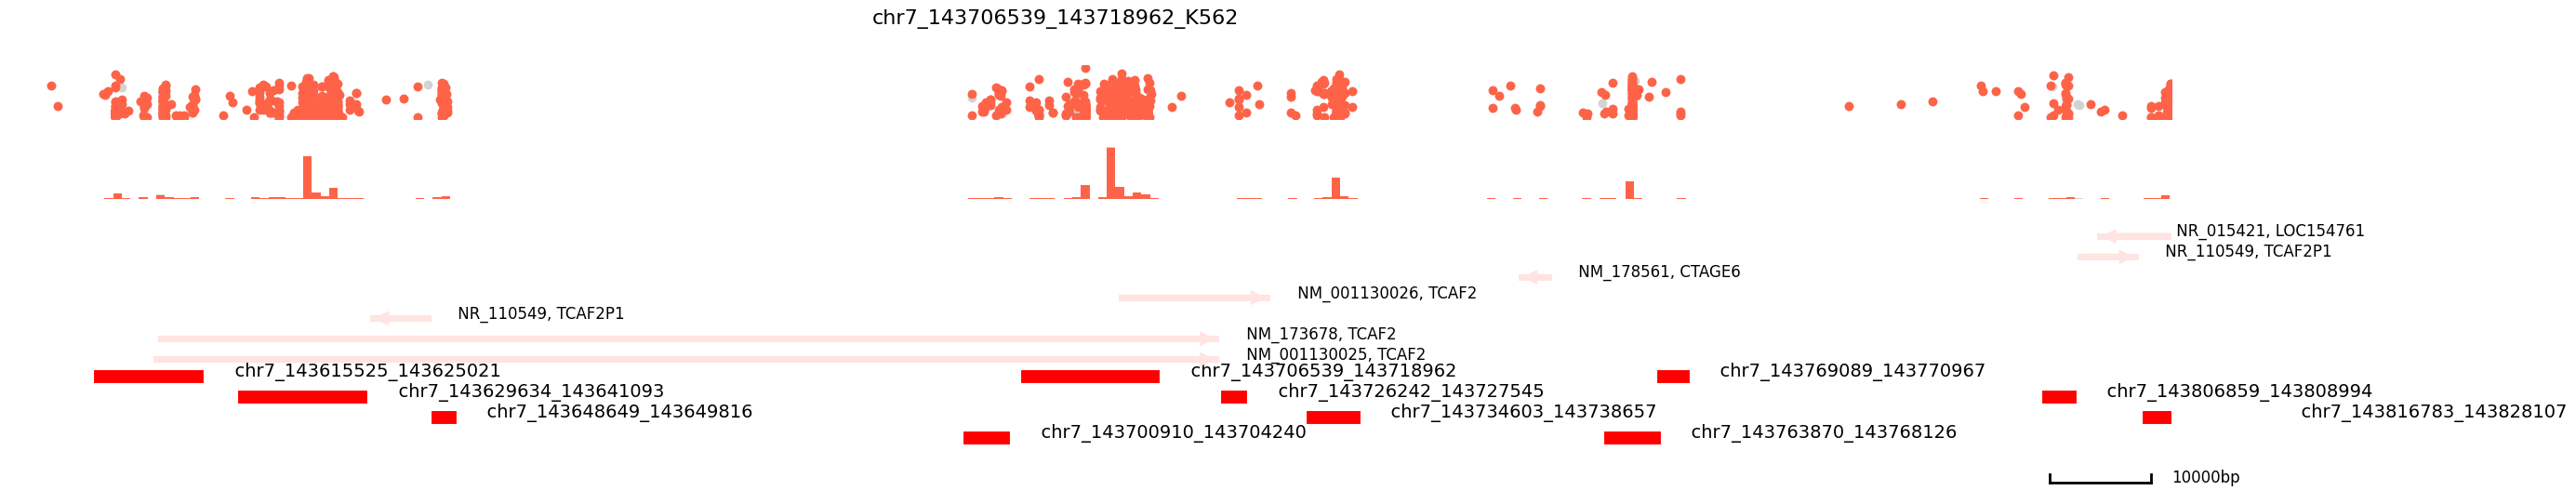

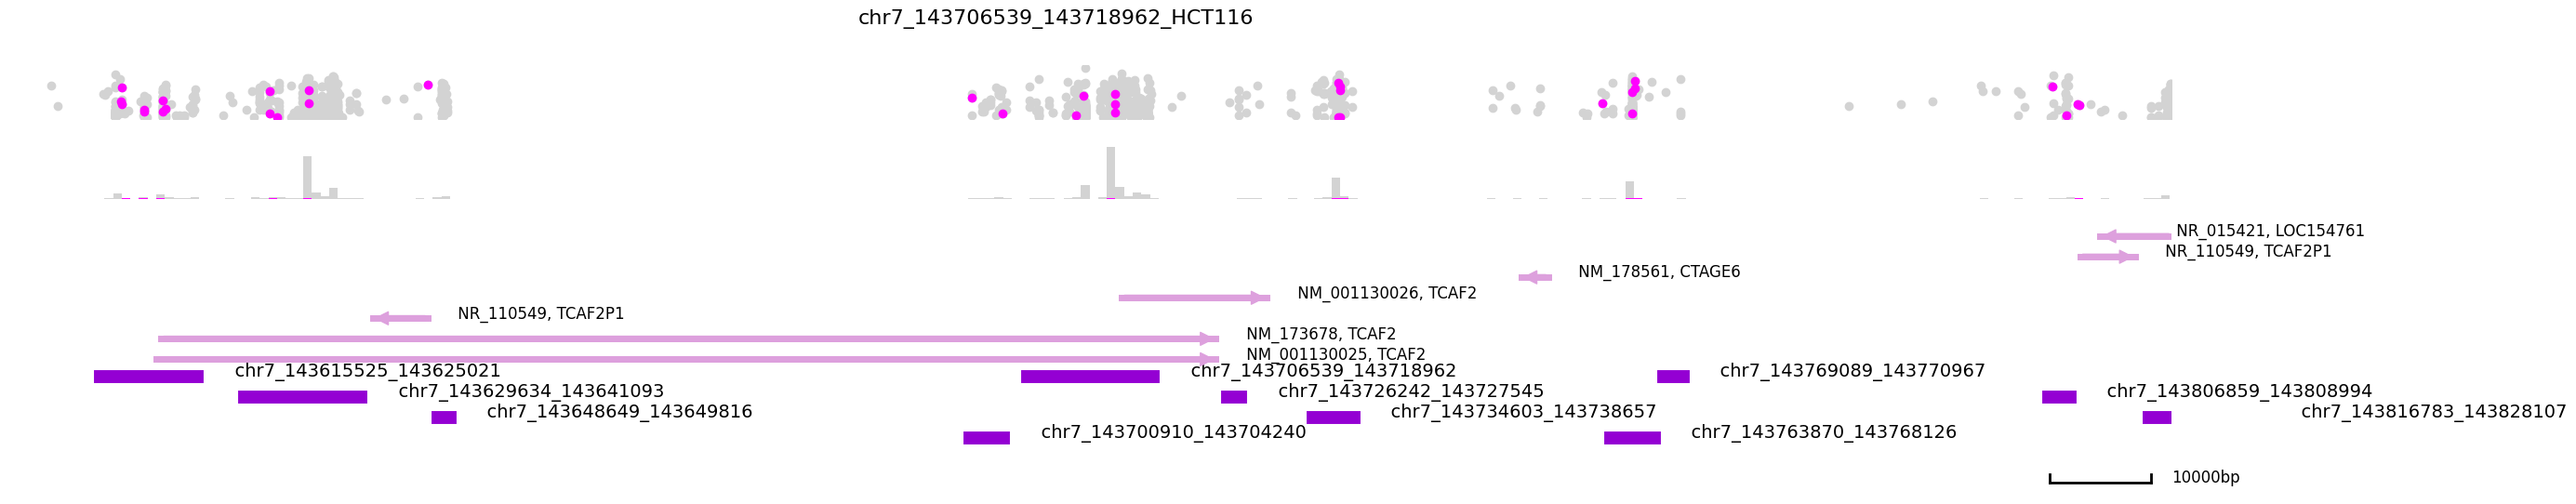

In [34]:
cc.pl.draw_area("chr7",143706539,143718962,100000,peak_data,exp_qbed,"hg38",adata = adata_cc, bins = 250,
                name = "K562",key ='cluster',figsize = (30,6),peak_line = 4,color = "red", plotsize = [1,1,5], title = "chr7_143706539_143718962_K562")
cc.pl.draw_area("chr7",143706539,143718962,100000,peak_data,exp_qbed,"hg38",adata = adata_cc,  bins = 250,
                name = "HCT116",key ='cluster',figsize = (30,6),peak_line = 4,color = "purple", plotsize = [1,1,5], title = "chr7_143706539_143718962_HCT116")

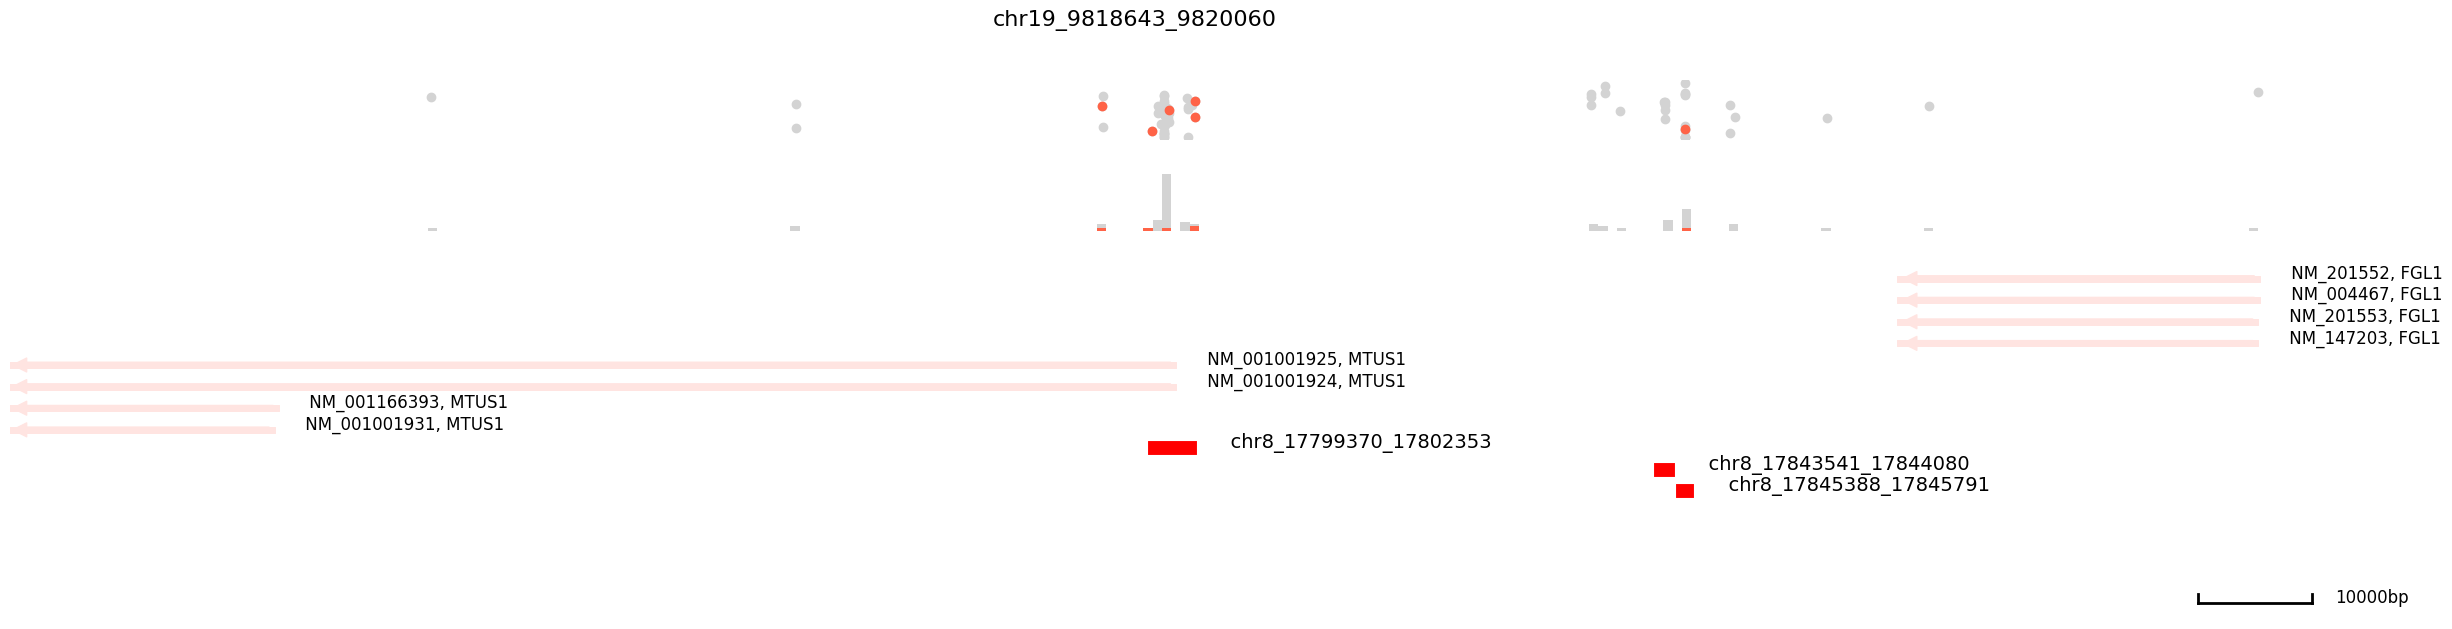

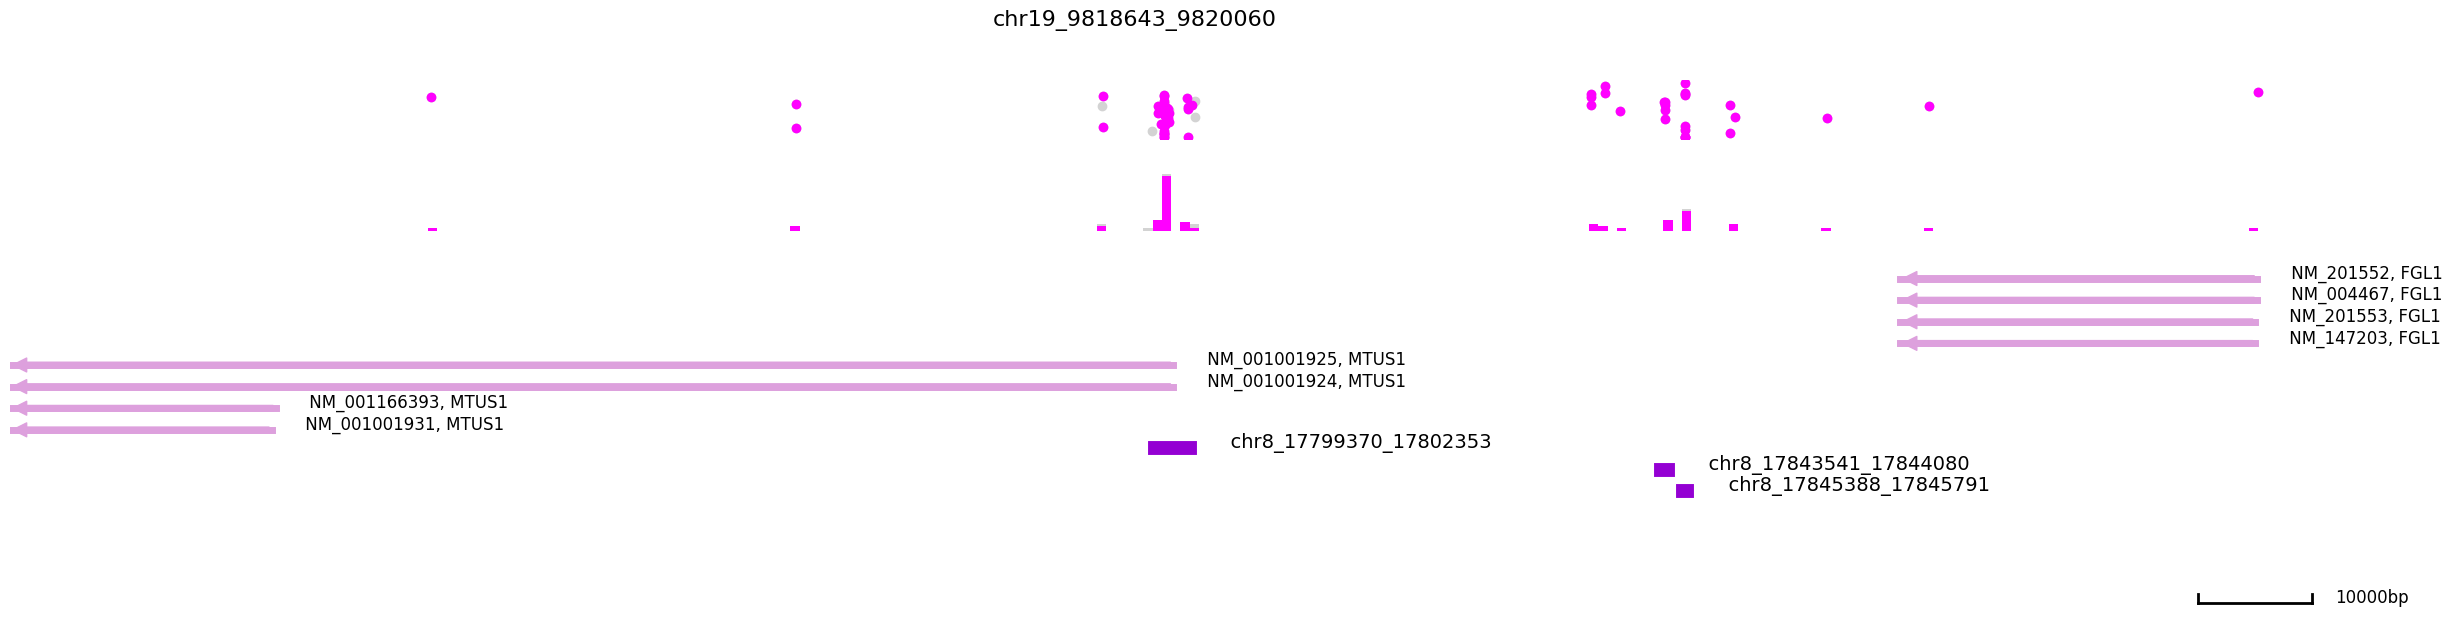

In [35]:
cc.pl.draw_area("chr8",17799370,17802353,100000,peak_data,exp_qbed,"hg38",adata = adata_cc,  bins = 250,
                name = "K562",key ='cluster',figsize = (30,7),peak_line = 6,color = "red", plotsize = [1,1,6], title = "chr19_9818643_9820060")
cc.pl.draw_area("chr8",17799370,17802353,100000,peak_data,exp_qbed,"hg38",adata = adata_cc,  bins = 250,
                name = "HCT116",key ='cluster',figsize = (30,7),peak_line = 6,color = "purple", plotsize = [1,1,6], title = "chr19_9818643_9820060")

Saved the file if needed.

In [36]:
adata_cc.write("SP1_qbed.h5ad")